# ABS Detailed Labour Force 6291

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-data-from-ABS" data-toc-modified-id="Get-data-from-ABS-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data from ABS</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot</a></span><ul class="toc-item"><li><span><a href="#Set-up-some-constants-we-will-use-across-all-plots" data-toc-modified-id="Set-up-some-constants-we-will-use-across-all-plots-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Set-up some constants we will use across all plots</a></span></li><li><span><a href="#By-Age" data-toc-modified-id="By-Age-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>By Age</a></span></li><li><span><a href="#Quarterly-by-sector" data-toc-modified-id="Quarterly-by-sector-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Quarterly by sector</a></span></li><li><span><a href="#Duration-of-unemployment" data-toc-modified-id="Duration-of-unemployment-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Duration of unemployment</a></span></li></ul></li><li><span><a href="#Finished" data-toc-modified-id="Finished-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Finished</a></span></li></ul></div>

## Python set-up

In [1]:
# system imports
import pathlib
import calendar
import datetime

# analytic imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# local imports
from finalise_plot import finalise_plot
from abs_common import (
    get_fs_constants,
    get_plot_constants,
    get_ABS_meta_and_data,
    get_identifier,
    plot_Mgrowth,
    recalibrate_series,
)

# pandas display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# plotting stuff
plt.style.use('ggplot')

In [2]:
catalogue_id = '6291'
source, CHART_DIR, META_DATA = get_fs_constants(catalogue_id)

## Get data from ABS

In [3]:
# do the data capture and extraction to a DataFrame
abs_m = get_ABS_meta_and_data(catalogue_id)
if abs_m is None:
    sys.exit(-1)
    
abs_q = get_ABS_meta_and_data(catalogue_id, 2)
if abs_q is None:
    sys.exit(-1)

Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...
Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...


## Plot

### Set-up some constants we will use across all plots

In [4]:
# monthly data
meta_m = abs_m[META_DATA]
RECENT_M, plot_times, plot_tags = get_plot_constants(meta_m)

# quarterly data
meta_q = abs_q[META_DATA]
RECENT_Q, plot_times_q, plot_tags_q = get_plot_constants(meta_q)

### By Age

In [5]:
table = '01'
data = abs_m[table]
series_type = 'Original'

ages = [
    '15-24 years',
    '25-34 years',
    '35-44 years',
    '45-54 years',
    '55-64 years',
]

TOKEN = 'By Age'
plots = [
    f'> {TOKEN} ;  Participation rate ;  Persons ;',
    f'> {TOKEN} ;  Unemployment rate ;  Persons ;',
]

for plot in plots:
    idents = []
    for age in ages:
        desc = plot.replace(TOKEN, age)
        ident, units = get_identifier(meta_m, desc, series_type, table)
        idents.append(ident)
        
    for start, tag in zip(plot_times, plot_tags):
        df = data[data.index >= pd.Period(start, freq=data.index.freq)] if start else data
        ax = df[idents].plot(lw=2)
        ax.legend(ages, loc='best')
        title = f'Australia: {plot}'
        finalise_plot(ax, title, units, tag, CHART_DIR,
                      rfooter=f'{source} {table}',
                      lfooter=f'{series_type.capitalize()} series',
                      #show=True,
                     )

### Quarterly by sector

In [6]:
table = '04'
data_table = abs_q[table]
series_type = 'Seasonally Adjusted'
selection = meta_q[
    (meta_q['Series Type'] == series_type)
    & (meta_q['Table'] == table)
]

for index, series in selection.iterrows():
    title = (
        series['Data Item Description']
        .replace(' ;', '')
        .replace('  ', ' ')
    )
    id = series['Series ID']
    units = series['Unit']
    data = data_table[id]
    data, units = recalibrate_series(data, units)
    tag = 'all'
    ax = data.plot(lw=2)
    finalise_plot(ax, title, units, tag, CHART_DIR,
                  rfooter=f'{source} {table}',
                  lfooter=f'{series_type.capitalize()} series',
                  #show=True,
                 )
    plt.close()

### Duration of unemployment

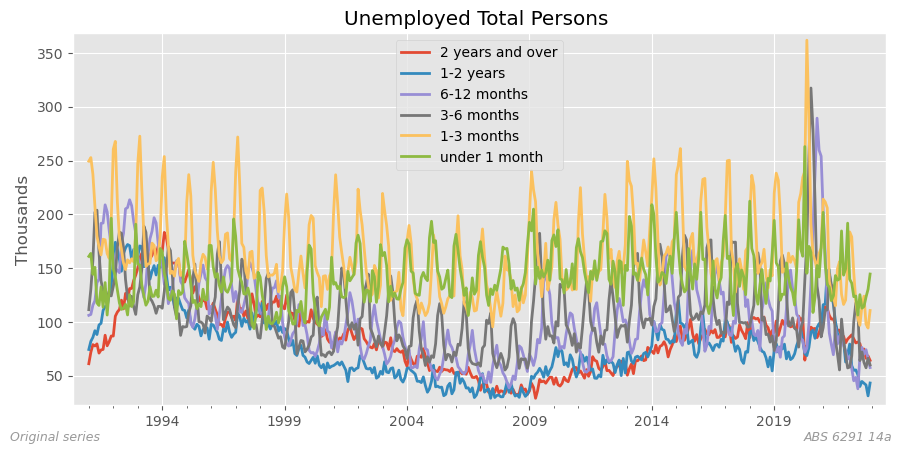

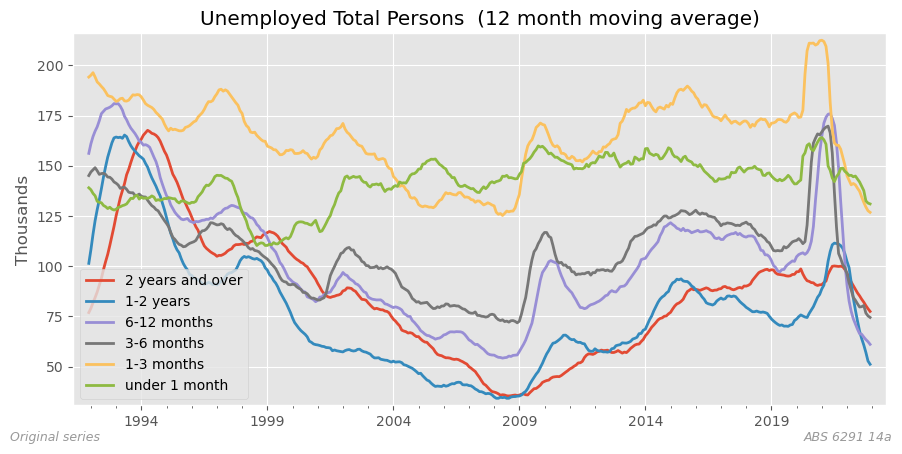

In [7]:
table = '14a'
df = abs_m[table]
series_type = 'Original'

cohorts = [
    '2 years and over',
    '1-2 years',
    '6-12 months',
    '3-6 months',
    '1-3 months',
    'under 1 month',
]

categories = [
    'Unemployed total ;  Persons ;'
]

did = 'Data Item Description'
period = 12
for category in categories:
    ax = None
    trend = pd.DataFrame()
    for cohort in cohorts:
        rows = meta_m[
            meta_m[did].str.contains(category) 
            & meta_m[did].str.contains(cohort) 
        ] 
        assert len(rows) == 1 
        select = rows['Series ID'].values[0]
        units = rows['Unit'].values[0]
        ax = df[select].plot(lw=2, ax=ax, label=cohort)
        trend[cohort] = df[select].rolling(period).mean()
    
    title = (
        category
        .replace(' ; ', ' ')
        .replace(' ;', ' ')
        .replace('  ', ' ')
        .title()
    )
    ax.legend(loc='best')
    finalise_plot(ax, title, units, 
                  tag, CHART_DIR,
                  rfooter=f'{source} {table}',
                  lfooter=f'{series_type.capitalize()} series',
                  show=True,
                  )    
    
    ax = trend.plot(lw=2)
    ax.legend(loc='best')
    finalise_plot(ax, title + f' ({period} month moving average)', 
                  units, tag, CHART_DIR,
                  rfooter=f'{source} {table}',
                  lfooter=f'{series_type.capitalize()} series',
                  show=True,
                  )

## Finished

In [9]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Mon Feb 06 2023 12:32:33

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.7.0

matplotlib: 3.6.3
pandas    : 1.5.3
numpy     : 1.24.1

Watermark: 2.3.1



In [8]:
print('Finished')

Finished
